In [10]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps
import time

## Download and load the dataset

In [3]:
ds,info = tfds.load('coco/2017', split='test', shuffle_files=True,with_info=True)


## Load and save model

In [4]:
detector = hub.load("https://tfhub.dev/tensorflow/ssd_mobilenet_v2/2")

In [9]:
images=[]
for count,example in enumerate(ds):  # example is `{'image': tf.Tensor, 'label': tf.Tensor}`
  images.append(example["image"])
  if count==10: break

In [ ]:
detector_output

In [37]:
def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)


def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  """Adds a bounding box to an image."""
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = top + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin


def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.5):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      display_str = "{}: {}%".format(class_names[i],
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image

In [34]:
def run_inference(image):
    start_time = time.time()
    processed_image = tf.expand_dims(image, 0)
    start_time = time.time()
    result= detector(processed_image)
    end_time = time.time()
    result = {key: value.numpy() for key, value in result.items()}
    scores = result["detection_scores"]
    boxes = result["detection_boxes"]
    classes = result["detection_classes"]
    boxes = np.squeeze(boxes)
    classes = np.squeeze(classes)
    scores=np.squeeze(scores)
    num_detections = result['num_detections']
    image_with_boxes=draw_boxes(image.numpy(),boxes,classes,scores)
    display_image(image_with_boxes)

Font not found, using default font.


C:\Users\marti\AppData\Local\Temp\ipykernel_14968\3312035812.py:29: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
C:\Users\marti\AppData\Local\Temp\ipykernel_14968\3312035812.py:39: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  text_width, text_height = font.getsize(display_str)


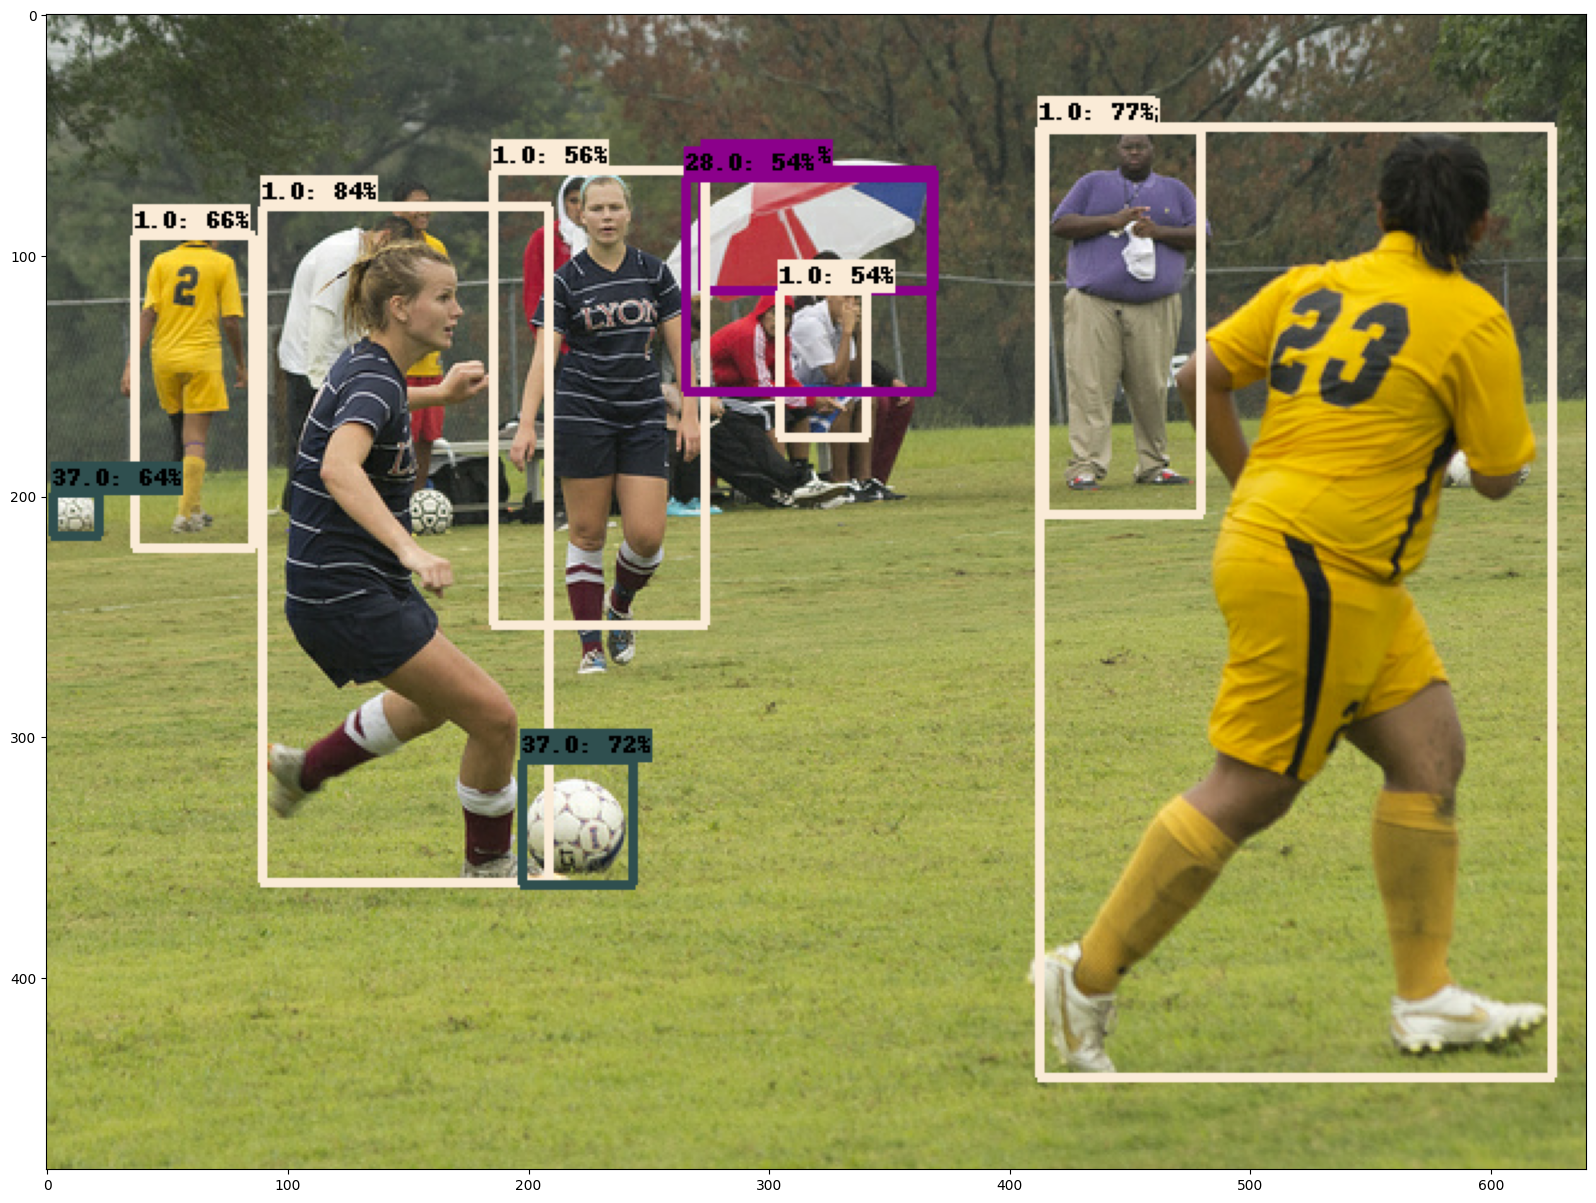

In [38]:
run_inference(images[2])

<PrefetchDataset element_spec={'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'image/filename': TensorSpec(shape=(), dtype=tf.string, name=None), 'image/id': TensorSpec(shape=(), dtype=tf.int64, name=None), 'objects': {'area': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'bbox': TensorSpec(shape=(None, 4), dtype=tf.float32, name=None), 'id': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'is_crowd': TensorSpec(shape=(None,), dtype=tf.bool, name=None), 'label': TensorSpec(shape=(None,), dtype=tf.int64, name=None)}}>